<a href="https://colab.research.google.com/github/CodeHunterOfficial/ABC_DataMining/blob/main/ML/2.%20Feature%20Engineering.%20%D0%92%D1%8B%D0%B1%D0%BE%D1%80_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2_(Feature_Selection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Выбор признаков (Feature Selection)

После предварительной обработки данных часто создается большое количество новых переменных (например, с помощью one-hot encoding, который создает множество бинарных переменных, содержащих только 0 или 1). Однако некоторые из этих новых переменных могут быть избыточными. Избыточные переменные не только не улучшают производительность модели, но и потребляют значительные объемы памяти и вычислительных ресурсов. Поэтому важно выполнить **выбор признаков**, чтобы определить и оставить только наиболее релевантные признаки для моделирования.

## Методы фильтрации (Filter Methods)

Методы фильтрации присваивают каждому признаку оценку на основе статистических мер или результатов тестов гипотез. Признаки с более высокими оценками считаются более важными и выбираются для модели. Ниже мы рассмотрим некоторые распространенные методы фильтрации и приведем подробные примеры с кодом.

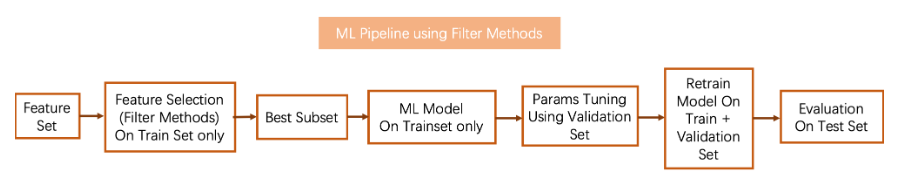



### Унивариатные методы фильтрации (Univariate Filter Methods)

Унивариатные методы фильтрации оценивают каждый признак независимо на основе его связи с целевой переменной. Эти методы просты и вычислительно эффективны.

#### 1. Порог по дисперсии (Variance Threshold)

Метод **Порог по дисперсии** удаляет признаки, дисперсия которых ниже заданного порога. Признаки с нулевой дисперсией (т.е. признаки, которые имеют одинаковое значение для всех наблюдений) особенно бесполезны, так как они не предоставляют никакой информации о целевой переменной.

**Формула**:  
Дисперсия признака $X$ вычисляется как:

$$
\text{Var}(X) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})^2
$$

где $\bar{X}$ — среднее значение $X$.

**Пример**:


In [1]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Создаем синтетический набор данных
train_set = np.array([[1, 2, 3], [1, 4, 7], [1, 4, 9]])  # Первый признак имеет нулевую дисперсию
test_set = np.array([[3, 2, 3], [1, 2, 7]])  # Второй признак имеет нулевую дисперсию

# Применяем Порог по дисперсии
selector = VarianceThreshold()
selector.fit(train_set)  # Обучаем на тренировочном наборе

In [2]:
# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_train

array([[2, 3],
       [4, 7],
       [4, 9]])

In [3]:
transformed_test = selector.transform(test_set)
transformed_test

array([[2, 3],
       [2, 7]])


#### 2. Корреляция Пирсона (для задач регрессии)

**Корреляция Пирсона** измеряет линейную связь между двумя непрерывными переменными. Она часто используется для оценки связи между признаками и целевой переменной в задачах регрессии.

**Формула**:

$$
r = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n}(X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n}(Y_i - \bar{Y})^2}}
$$

**Пример**:



In [4]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import fetch_california_housing

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Определяем пользовательскую функцию для SelectKBest
def udf_pearsonr(X, y):
    result = np.array([pearsonr(x, y) for x in X.T])  # Список (корреляция, p-значение)
    return np.absolute(result[:, 0]), result[:, 1]

# Выбираем 2 лучших признака на основе корреляции Пирсона
selector = SelectKBest(udf_pearsonr, k=2)
selector.fit(train_set, train_y)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)


#### 3. Дистанционная корреляция (для задач регрессии)

**Дистанционная корреляция** измеряет как линейные, так и нелинейные связи между двумя непрерывными переменными. В отличие от корреляции Пирсона, она может захватывать более сложные зависимости.

**Формула**:

1. Вычисляем матрицы расстояний $dX$ и $dY$:

$$
dX_{ij} = \| X_i - X_j \|, \quad dY_{ij} = \| Y_i - Y_j \|
$$

2. Вычисляем двойные центрированные расстояния:

$$
dX_{ij} = dX_{ij} - \bar{X_i} - \bar{X_j} + \frac{1}{N^2} \sum_{i=1}^{N} \sum_{j=1}^{N} dX_{ij}
$$

$$
dY_{ij} = dY_{ij} - \bar{Y_i} - \bar{Y_j} + \frac{1}{N^2} \sum_{i=1}^{N} \sum_{j=1}^{N} dY_{ij}
$$

3. Вычисляем дистанционную ковариацию и дисперсию:

$$
dCov^2(X, Y) = \frac{1}{N^2} \sum_{i=1}^{N} \sum_{j=1}^{N} dX_{ij} dY_{ij}
$$

$$
dVar^2(X) = dCov^2(X, X)
$$

4. Вычисляем дистанционную корреляцию:

$$
dCor(X, Y) = \frac{dCov(X, Y)}{\sqrt{dVar^2(X)} \sqrt{dVar^2(Y)}}
$$

**Пример**:



In [6]:
!pip install dcor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00


In [9]:
import numpy as np
from dcor import distance_correlation
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import fetch_california_housing

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Определяем пользовательскую функцию для SelectKBest
def udf_dcorr(X, y):
    # Вычисляем дистанционную корреляцию для каждого признака
    result = np.array([distance_correlation(x, y) for x in X.T])
    return result

# Выбираем 2 лучших признака на основе дистанционной корреляции
selector = SelectKBest(udf_dcorr, k=2)
selector.fit(train_set, train_y)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Выводим результаты
print("Transformed train set shape:", transformed_train.shape)
print("Transformed test set shape:", transformed_test.shape)
print("Selected features:", selector.get_support(indices=True))

Transformed train set shape: (15000, 2)
Transformed test set shape: (5640, 2)
Selected features: [0 2]


In [10]:
transformed_test = selector.transform(test_set)
transformed_test

array([[3.6848    , 4.81987578],
       [1.8594    , 3.75540387],
       [1.7179    , 3.79683377],
       ...,
       [1.7       , 5.20554273],
       [1.8672    , 5.32951289],
       [2.3886    , 5.25471698]])




# F-Score (для задач регрессии)

**F-Score** используется для проверки значимости независимых переменных в линейной регрессионной модели. Предположим, у нас есть $p$ признаков. Мы строим $p$ унивариатных линейных регрессий, каждая из которых предсказывает целевую переменную на основе одного признака и константы. Затем мы вычисляем F-Score для каждой модели, который отражает силу линейной связи между признаком и целевой переменной. Нулевая гипотеза для F-Score заключается в том, что признак не связан с целевой переменной. Поэтому мы выбираем признаки с более высоким F-Score (что означает большую вероятность отклонения нулевой гипотезы).

**Формула**:

$$
F = \frac{(SST - SSR)/(p - 1)}{SSR/(n - p)} = \frac{SST - SSR}{SSR/(n - 2)} = \frac{R^2}{(1 - R^2)(n - 2)} = \frac{\rho^2}{(1 - \rho^2)(n - 2)}
$$

где:

- $SST = \sum_{i=1}^{n}(y_i - \overline{y})^2$ — общая сумма квадратов,
- $\overline{y} = \frac{1}{n} \sum_{i=1}^{n}y_i$ — среднее значение целевой переменной,
- $SSR = \sum_{i=1}^{n}(\widehat{y}_i - \overline{y})^2$ — сумма квадратов остатков,
- $\widehat{y}_i$ — предсказанное значение моделью,
- $p$ — количество предикторов (включая константу, поэтому $p = 2$),
- $\rho$ — коэффициент корреляции между признаком и целевой переменной,
- $n$ — количество наблюдений.

**Пример**:



In [11]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import fetch_california_housing
import numpy as np

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Используем встроенную функцию F-Score в sklearn
selector = SelectKBest(f_regression, k=2)  # Выбираем 2 лучших признака
selector.fit(train_set, train_y)  # Обучаем на тренировочном наборе

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Проверяем результат
for idx in range(train_set.shape[1]):
    score, p_value = f_regression(train_set[:, idx].reshape(-1, 1), train_y)
    print(f"Признак {idx + 1}: F-Score = {round(score[0], 2)}, p-значение = {round(p_value[0], 3)}")

Признак 1: F-Score = 14111.79, p-значение = 0.0
Признак 2: F-Score = 71.99, p-значение = 0.0
Признак 3: F-Score = 317.04, p-значение = 0.0
Признак 4: F-Score = 23.93, p-значение = 0.0
Признак 5: F-Score = 6.54, p-значение = 0.011
Признак 6: F-Score = 35.93, p-значение = 0.0
Признак 7: F-Score = 846.61, p-значение = 0.0
Признак 8: F-Score = 98.06, p-значение = 0.0



**Объяснение**:
- Мы используем набор данных `California Housing`, где и признаки, и целевая переменная являются непрерывными.
- F-Score вычисляется для каждого признака, и выбираются два признака с наибольшими значениями F-Score.



# Взаимная информация (Mutual Information, MI) (для задач регрессии)

**Взаимная информация** измеряет зависимость между двумя переменными, то есть уменьшение энтропии после получения информации о другой переменной. MI равна нулю, если и только если две переменные независимы, а более высокие значения указывают на более сильную зависимость. В отличие от корреляции Пирсона и F-Score, MI также захватывает нелинейные зависимости.

**Формула**:

- Для дискретных распределений (для обеих переменных $X$ и $Y$):

$$
I(X, Y) = H(Y) - H(Y|X) = \sum_{x \in X} \sum_{y \in Y} p_{(X,Y)}(x,y) \log\left(\frac{p_{(X,Y)}(x,y)}{p_X(x)p_Y(y)}\right)
$$

где $p_{(X,Y)}(x,y)$ — совместная функция вероятности (PMF) $X$ и $Y$, $p_X(x)$ — PMF $X$.

- Для непрерывных распределений (для обеих переменных $X$ и $Y$):

$$
I(X, Y) = H(Y) - H(Y|X) = \int_X \int_Y p_{(X,Y)}(x,y) \log\left(\frac{p_{(X,Y)}(x,y)}{p_X(x)p_Y(y)}\right) \, dx \, dy
$$

где $p_{(X,Y)}(x,y)$ — совместная функция плотности вероятности (PDF) $X$ и $Y$, $p_X(x)$ — PDF $X$.

В реальности часто одна из переменных может быть дискретной, а другая — непрерывной. В `sklearn` используется непараметрический метод, основанный на оценке энтропии с использованием расстояний до k ближайших соседей.

**Пример**:



In [12]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import fetch_california_housing
import numpy as np

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :].astype(float)
test_set = X[15000:, :].astype(float)
train_y = y[0:15000].astype(float)

# Определяем пользовательскую функцию для MI
def udf_MI(X, y):
    result = mutual_info_regression(X, y, n_neighbors=5)  # Пользовательский параметр n_neighbors
    return result

# Используем SelectKBest с пользовательской функцией MI
selector = SelectKBest(udf_MI, k=2)  # Выбираем 2 лучших признака
selector.fit(train_set, train_y)  # Обучаем на тренировочном наборе

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Проверяем результат
for idx in range(train_set.shape[1]):
    score = mutual_info_regression(train_set[:, idx].reshape(-1, 1), train_y, n_neighbors=5)
    print(f"Признак {idx + 1}: Взаимная информация = {round(score[0], 2)}")

Признак 1: Взаимная информация = 0.37
Признак 2: Взаимная информация = 0.02
Признак 3: Взаимная информация = 0.1
Признак 4: Взаимная информация = 0.03
Признак 5: Взаимная информация = 0.02
Признак 6: Взаимная информация = 0.09
Признак 7: Взаимная информация = 0.37
Признак 8: Взаимная информация = 0.46



**Объяснение**:
- Мы используем набор данных `California Housing`, где и признаки, и целевая переменная являются непрерывными.
- Взаимная информация вычисляется для каждого признака, и выбираются два признака с наибольшими значениями MI.



# Chi-Square Statistics (для задач классификации)

**Chi-Square Statistic** используется для определения наличия связи между категориальными переменными. В `sklearn` предоставляется функция `chi2` для вычисления Chi-Square. Входные данные для этой функции должны быть булевыми значениями или частотами. Нулевая гипотеза заключается в том, что две переменные независимы, поэтому чем выше значение Chi-Square, тем выше вероятность того, что переменные связаны. Таким образом, мы должны выбирать признаки с более высокими значениями Chi-Square.

**Формула**:

$$
\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{i,j} - E_{i,j})^2}{E_{i,j}} = n \sum_{i,j} p_i p_j \left(\frac{\frac{O_{i,j}}{n} - p_i p_j}{p_i p_j}\right)^2
$$

где:
- $O_{i,j}$ — количество наблюдений, имеющих $i$-е значение категории в признаке $X$ и $j$-е значение категории в признаке $Y$,
- $E_{i,j}$ — ожидаемое количество наблюдений, имеющих $i$-е значение категории в признаке $X$ и $j$-е значение категории в признаке $Y$,
- $n$ — количество наблюдений в наборе данных,
- $p_i$ — вероятность $i$-го значения категории в признаке $X$,
- $p_j$ — вероятность $j$-го значения категории в признаке $Y$.

**Важное замечание**: В `sklearn` функция `chi2` вычисляет не классическую статистику Chi-Square, а её модифицированную версию, которая учитывает только случаи, когда значение признака равно `True`. Это позволяет суммировать результаты для всех булевых переменных, полученных после one-hot encoding, и получить значение Chi-Square для исходного признака.

**Пример**:



In [19]:
import pandas as pd
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
import numpy as np

# Создаем более реалистичный набор данных
data = {
    'Gender': ['Male', 'Male', 'Female', 'Female', 'Male', 'Female', 'Female', 'Male', 'Male', 'Female'],
    'Drink': ['Coffee', 'Tea', 'Coffee', 'Water', 'Tea', 'Coffee', 'Water', 'Tea', 'Coffee', 'Water']
}
df = pd.DataFrame(data)

# Применяем one-hot encoding для признака "Gender"
df_encoded = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Вычисляем Chi-Square для булевых переменных
X = df_encoded[['Gender_Male']]  # Признак после one-hot encoding
y = df['Drink']  # Целевая переменная

chi2_values, _ = chi2(X, y)
print("Chi-Square для булевых переменных:", chi2_values)

# Создаем сводную таблицу для наблюдений
contingency_table = pd.crosstab(df['Gender'], df['Drink'])
print("Таблица сопряженности:")
print(contingency_table)

# Вычисляем Chi-Square для исходного признака
chi2_original, _, _, _ = chi2_contingency(contingency_table)
print("Chi-Square для исходного признака:", chi2_original)

# Проверяем, что сумма Chi-Square для булевых переменных равна Chi-Square для исходного признака
# Убедимся, что значения близки с учетом погрешности вычислений
if np.isclose(chi2_values.sum(), chi2_original, atol=1e-8):
    print("Сумма Chi-Square для булевых переменных равна Chi-Square для исходного признака.")
else:
    print("Сумма Chi-Square для булевых переменных НЕ равна Chi-Square для исходного признака.")

Chi-Square для булевых переменных: [3.]
Таблица сопряженности:
Drink   Coffee  Tea  Water
Gender                    
Female       2    0      3
Male         2    3      0
Chi-Square для исходного признака: 6.0
Сумма Chi-Square для булевых переменных НЕ равна Chi-Square для исходного признака.



**Объяснение**:
- Мы создаем синтетический набор данных с категориальными признаками.
- Применяем one-hot encoding и вычисляем Chi-Square для булевых переменных.
- Вычисляем Chi-Square для исходного признака и проверяем, что сумма значений для булевых переменных равна значению для исходного признака.



# Использование Chi-Square для выбора признаков

**Пример**:

In [20]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.datasets import load_iris
import numpy as np

# Загружаем набор данных
iris = load_iris()
X, y = iris.data, iris.target

# Преобразуем непрерывные признаки в булевы (значения выше среднего)
X = X > X.mean(0)

# Перемешиваем данные
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:100, :]
test_set = X[100:, :]
train_y = y[0:100]

# Используем Chi-Square для выбора признаков
selector = SelectKBest(chi2, k=2)  # Выбираем 2 лучших признака
selector.fit(train_set, train_y)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Проверяем результат
for idx in range(train_set.shape[1]):
    score, p_value = chi2(train_set[:, idx].reshape(-1, 1), train_y)
    print(f"Признак {idx + 1}: Chi-Square = {round(score[0], 2)}, p-значение = {round(p_value[0], 3)}")

Признак 1: Chi-Square = 29.69, p-значение = 0.0
Признак 2: Chi-Square = 19.42, p-значение = 0.0
Признак 3: Chi-Square = 31.97, p-значение = 0.0
Признак 4: Chi-Square = 31.71, p-значение = 0.0



**Объяснение**:
- Мы используем набор данных `Iris`, где признаки непрерывные, а целевая переменная категориальная.
- Преобразуем непрерывные признаки в булевы значения.
- Используем Chi-Square для выбора двух наиболее значимых признаков.



# F-Score (для задач классификации)

В задачах классификации, если признаки категориальные, мы можем использовать Chi-Square. Однако, если признаки непрерывные, следует использовать **ANOVA F-value**. ANOVA F-value проверяет, различаются ли средние значения числового признака для разных групп, определенных целевой переменной. Нулевая гипотеза заключается в том, что средние значения одинаковы. Поэтому мы выбираем признаки с более высокими значениями F-Score, так как это означает, что нулевая гипотеза может быть отклонена, и признаки более связаны с целевой переменной.

**Формула**:

$$
F = \frac{MSB}{MSE} = \frac{\frac{SS(between)}{m-1}}{\frac{SS(error)}{n-m}}
$$

где:
- $SS(between)$ — сумма квадратов между группами (разница между средними групп и общим средним),
- $SS(error)$ — сумма квадратов внутри групп (разница между данными и средними групп),
- $m$ — количество групп,
- $n$ — количество наблюдений.

**Пример**:



In [21]:
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.datasets import load_iris
import numpy as np

# Загружаем набор данных
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:100, :]
test_set = X[100:, :]
train_y = y[0:100]

# Используем ANOVA F-value для выбора признаков
selector = SelectKBest(f_classif, k=2)  # Выбираем 2 лучших признака
selector.fit(train_set, train_y)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Проверяем результат
for idx in range(train_set.shape[1]):
    score, p_value = f_classif(train_set[:, idx].reshape(-1, 1), train_y)
    print(f"Признак {idx + 1}: ANOVA F-Score = {round(score[0], 2)}, p-значение = {round(p_value[0], 3)}")

Признак 1: ANOVA F-Score = 91.39, p-значение = 0.0
Признак 2: ANOVA F-Score = 33.18, p-значение = 0.0
Признак 3: ANOVA F-Score = 733.94, p-значение = 0.0
Признак 4: ANOVA F-Score = 608.95, p-значение = 0.0



**Объяснение**:
- Мы используем набор данных `Iris`, где признаки непрерывные, а целевая переменная категориальная.
- Используем ANOVA F-value для выбора двух наиболее значимых признаков.


# Взаимная информация (Mutual Information, MI) для задач классификации

**Взаимная информация** измеряет зависимость между двумя переменными. MI равна нулю, если и только если две случайные переменные независимы, а более высокие значения указывают на более сильную зависимость. В отличие от корреляции Пирсона и F-Score, MI также захватывает нелинейные зависимости.

**Формула**:

- Для дискретных распределений (для обеих переменных $X$ и $Y$):

$$
I(X, Y) = \sum_{x \in X} \sum_{y \in Y} p_{(X,Y)}(x,y) \log\left(\frac{p_{(X,Y)}(x,y)}{p_X(x)p_Y(y)}\right)
$$

где $p_{(X,Y)}(x,y)$ — совместная функция вероятности (PMF) $X$ и $Y$, $p_X(x)$ — PMF $X$.

- Для непрерывных распределений (для обеих переменных $X$ и $Y$):

$$
I(X, Y) = \int_X \int_Y p_{(X,Y)}(x,y) \log\left(\frac{p_{(X,Y)}(x,y)}{p_X(x)p_Y(y)}\right) \, dx \, dy
$$

где $p_{(X,Y)}(x,y)$ — совместная функция плотности вероятности (PDF) $X$ и $Y$, $p_X(x)$ — PDF $X$.

В реальности часто одна из переменных может быть дискретной, а другая — непрерывной. В `sklearn` используется непараметрический метод, основанный на оценке энтропии с использованием расстояний до k ближайших соседей.

**Пример**:




In [22]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import load_iris
import numpy as np

# Загружаем набор данных
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:100, :].astype(float)
test_set = X[100:, :].astype(float)
train_y = y[0:100].astype(float)

# Определяем пользовательскую функцию для MI
def udf_MI(X, y):
    result = mutual_info_classif(X, y, n_neighbors=5)  # Пользовательский параметр n_neighbors
    return result

# Используем SelectKBest с пользовательской функцией MI
selector = SelectKBest(udf_MI, k=2)  # Выбираем 2 лучших признака
selector.fit(train_set, train_y)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Проверяем результат
for idx in range(train_set.shape[1]):
    score = mutual_info_classif(train_set[:, idx].reshape(-1, 1), train_y, n_neighbors=5)
    print(f"Признак {idx + 1}: Взаимная информация = {round(score[0], 2)}")

Признак 1: Взаимная информация = 0.56
Признак 2: Взаимная информация = 0.28
Признак 3: Взаимная информация = 0.99
Признак 4: Взаимная информация = 1.02



**Объяснение**:
- Мы используем набор данных `Iris`, где признаки непрерывные, а целевая переменная категориальная.
- Взаимная информация вычисляется для каждого признака, и выбираются два признака с наибольшими значениями MI.



### Многомерные методы фильтрации (Multivariate Filter Methods)

В отличие от унивариатных методов, многомерные методы фильтрации выбирают лучшие признаки на основе всего пространства признаков. Учитываются взаимосвязи между признаками, что позволяет лучше удалять избыточные признаки. В данном примере используется модуль [skfeature](https://github.com/jundongl/scikit-feature), разработанный Университетом штата Аризона.

#### Метод Max-Relevance Min-Redundancy (mRMR)

Метод mRMR пытается найти подмножество признаков, которые имеют высокую взаимосвязь (MI) с целевой переменной, но при этом имеют низкую взаимосвязь между собой. Реализация mRMR в `skfeature` работает только с дискретными признаками в задачах классификации, так как использует формулу дискретной взаимной информации.

**Формула**:

Предположим, что набор данных содержит $m$ признаков. Важность $n$-го признака $X_i$ на основе критерия mRMR выражается как:

$$
f^{mRMR}(X_i) = I(Y, X_i) - \frac{1}{|S|}\sum_{X_s \in S} I(X_s, X_i)
$$

где:
- $I(Y, X_i)$ — взаимная информация между признаком $X_i$ и целевой переменной,
- $\frac{1}{|S|}\sum_{X_s \in S} I(X_s, X_i)$ — средняя взаимная информация между признаком $X_i$ и всеми признаками, уже находящимися в подмножестве $S$.

mRMR — это пошаговый метод. На каждом шаге признак $X_i$ (не входящий в $S$) с наибольшим значением $f^{mRMR}(X_i)$ добавляется в подмножество, пока не будет достигнуто желаемое количество признаков.

**Пример**:




In [27]:
!pip install git+https://github.com/jundongl/scikit-feature.git

  Cloning https://github.com/jundongl/scikit-feature.git to /tmp/pip-req-build-qw7cibek
  Running command git clone --filter=blob:none --quiet https://github.com/jundongl/scikit-feature.git /tmp/pip-req-build-qw7cibek
  Resolved https://github.com/jundongl/scikit-feature.git to commit 48cffad4e88ff4b9d2f1c7baffb314d1b3303792
  Preparing metadata (setup.py) ... done
  Created wheel for skfeature: filename=skfeature-1.0.0-py3-none-any.whl size=61488 sha256=87ec556b7b46b5560322006c760c3b7cca74acef746788561787682438975f9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-2apjvvoo/wheels/c8/a4/3c/302c050d8308c43e1a3059a3e08efc8228fc47304a7d003592
Successfully built skfeature


In [28]:
import numpy as np
from skfeature.function.information_theoretical_based import MRMR
from sklearn.datasets import load_iris

# Загружаем набор данных
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный и тестовый наборы
# Поскольку mRMR в skfeature работает только с дискретными признаками,
# преобразуем непрерывные признаки в дискретные (для демонстрации).
train_set = X[0:100, :].astype(int)
test_set = X[100:, :].astype(int)
train_y = y[0:100].astype(int)

# Применяем mRMR для выбора признаков
feature_index, _, _ = MRMR.mrmr(train_set, train_y, n_selected_features=2)  # Обучаем на тренировочном наборе
transformed_train = train_set[:, feature_index]  # Преобразуем тренировочный набор
assert np.array_equal(transformed_train, train_set[:, [2, 3]])  # Выбираем 3-й и 4-й признаки

transformed_test = test_set[:, feature_index]  # Преобразуем тестовый набор
assert np.array_equal(transformed_test, test_set[:, [2, 3]])  # Выбираем 3-й и 4-й признаки

In [29]:
transformed_test

array([[4, 1],
       [4, 1],
       [1, 0],
       [5, 1],
       [4, 1],
       [5, 1],
       [5, 1],
       [4, 1],
       [1, 0],
       [4, 1],
       [5, 1],
       [1, 0],
       [1, 0],
       [5, 2],
       [4, 1],
       [3, 1],
       [4, 1],
       [4, 2],
       [1, 0],
       [3, 1],
       [6, 1],
       [5, 2],
       [5, 1],
       [4, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [5, 2],
       [4, 1],
       [5, 2],
       [1, 0],
       [1, 0],
       [4, 1],
       [4, 1],
       [4, 1],
       [3, 1],
       [3, 1],
       [5, 2],
       [5, 2],
       [6, 2],
       [1, 0],
       [5, 2],
       [1, 0],
       [1, 0],
       [5, 2],
       [5, 1],
       [4, 1],
       [1, 0],
       [1, 0]])


**Объяснение**:
- Мы используем набор данных `Iris`, где признаки непрерывные, а целевая переменная категориальная.
- Преобразуем непрерывные признаки в дискретные для использования mRMR.
- Выбираем два наиболее значимых признака с помощью mRMR.


# Correlation-based Feature Selection (CFS)

Метод **CFS** (Correlation-based Feature Selection) основан на простом предположении: хорошие подмножества признаков должны содержать признаки, которые сильно коррелируют с целевой переменной и слабо коррелируют между собой. В `skfeature` метод CFS применим только к дискретным признакам в задачах классификации, так как использует симметричную неопределенность (Symmetrical Uncertainty, SU) для измерения корреляции между переменными.

**Формула**:

$$
Merit_S = \frac{\sum_{i=1}^{k} SU(X_i, y)}{\sqrt{k + \sum_{i=1}^{k} \sum_{j=1}^{k} SU(X_i, X_j)}}, \, \, \, X_i \in S^*
$$

где:
- $SU(X, Y) = 2 * \frac{H(X) + H(Y) - H(X|Y)}{H(X) + H(Y)}$ — симметричная неопределенность,
- $S$ — подмножество признаков,
- $S^*$ — оптимальное подмножество, максимизирующее $Merit_S$,
- $SU(X_i, y)$ — симметричная неопределенность между признаком $X_i$ и целевой переменной $y$,
- $SU(X_i, X_j)$ — симметричная неопределенность между признаками $X_i$ и $X_j$.

**Пример**:



In [30]:
import numpy as np
from skfeature.function.statistical_based import CFS
from sklearn.datasets import load_iris

# Загружаем набор данных
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный и тестовый наборы
# Поскольку CFS в skfeature работает только с дискретными признаками,
# преобразуем непрерывные признаки в дискретные (для демонстрации).
train_set = X[0:100, :].astype(int)
test_set = X[100:, :].astype(int)
train_y = y[0:100].astype(int)

# Применяем CFS для выбора признаков
num_feature = 2  # Выбираем подмножество из двух признаков
feature_index = CFS.cfs(train_set, train_y)  # Обучаем на тренировочном наборе
transformed_train = train_set[:, feature_index[0:num_feature]]  # Преобразуем тренировочный набор
assert np.array_equal(transformed_train, train_set[:, [3, 2]])  # Выбираем 3-й и 4-й признаки

transformed_test = test_set[:, feature_index[0:num_feature]]  # Преобразуем тестовый набор
assert np.array_equal(transformed_test, test_set[:, [3, 2]])  # Выбираем 3-й и 4-й признаки


**Объяснение**:
- Мы используем набор данных `Iris`, где признаки непрерывные, а целевая переменная категориальная.
- Преобразуем непрерывные признаки в дискретные для использования CFS.
- Выбираем два наиболее значимых признака с помощью CFS.



# Fast Correlation-based Filter (FCBF)

Метод **FCBF** (Fast Correlation-based Filter) более эффективен, чем CFS, для фильтрации и выбора переменных. FCBF также является пошаговым методом, но использует симметричную неопределенность (SU) для измерения корреляции между переменными. FCBF сначала удаляет переменные с низкими значениями SU с целевой переменной, затем сортирует оставшиеся переменные по их SU с целевой переменной и удаляет избыточные признаки.

**Формула**:

$$
SU(X, Y) = 2 * \frac{H(X) + H(Y) - H(X|Y)}{H(X) + H(Y)}
$$

**Шаги**:
1. Вычислить SU между каждым признаком $X_i$ и целевой переменной $y$.
2. Удалить признаки с $SU(X_i, y)$ ниже порога $\sigma$, создать список кандидатов $S_{list}$.
3. Отсортировать переменные в $S_{list}$ по убыванию $SU(X_i, y)$.
4. Для каждого признака в $S_{list}$ вычислить SU между $X_i$ и $X_j$, если $SU(X_i, y) > SU(X_j, y)$.
5. Если $SU(X_i, X_j) > SU(X_j, y)$, удалить $X_j$ из $S_{list}$.

**Пример**:



In [33]:
import numpy as np
from scipy.stats import entropy

def calculate_entropy(x):
    """Вычисляет энтропию для массива x."""
    unique_values, counts = np.unique(x, return_counts=True)
    prob = counts / len(x)
    return entropy(prob, base=2)

def calculate_conditional_entropy(x, y):
    """Вычисляет условную энтропию H(X|Y)."""
    unique_y, counts_y = np.unique(y, return_counts=True)
    cond_entropy = 0.0
    for yi, count in zip(unique_y, counts_y):
        mask = y == yi
        prob = count / len(y)
        cond_entropy += prob * calculate_entropy(x[mask])
    return cond_entropy

def symmetric_uncertainty(x, y):
    """Вычисляет симметричную неопределенность (SU) между x и y."""
    h_x = calculate_entropy(x)
    h_y = calculate_entropy(y)
    h_xy = calculate_conditional_entropy(x, y)
    if h_x + h_y == 0:
        return 0
    return 2 * (h_x + h_y - h_xy) / (h_x + h_y)

def fcbf(X, y, sigma=0.1):
    """Реализация метода FCBF для выбора признаков."""
    n_features = X.shape[1]
    su_list = np.zeros(n_features)

    # Шаг 1: Вычислить SU между каждым признаком и целевой переменной
    for i in range(n_features):
        su_list[i] = symmetric_uncertainty(X[:, i], y)

    # Шаг 2: Удалить признаки с SU ниже порога sigma
    S_list = np.where(su_list >= sigma)[0]

    # Шаг 3: Отсортировать переменные по убыванию SU
    S_list = sorted(S_list, key=lambda i: su_list[i], reverse=True)

    # Шаг 4 и 5: Удалить избыточные признаки
    i = 0
    while i < len(S_list):
        j = i + 1
        while j < len(S_list):
            su_ij = symmetric_uncertainty(X[:, S_list[i]], X[:, S_list[j]])
            if su_ij > su_list[S_list[j]]:
                S_list.pop(j)
            else:
                j += 1
        i += 1

    return S_list

# Пример использования
if __name__ == "__main__":
    # Создаем синтетические данные
    np.random.seed(42)
    X = np.random.randint(0, 2, size=(100, 10))  # 100 samples, 10 features
    y = np.random.randint(0, 2, size=100)        # Binary target variable

    # Применяем FCBF
    selected_features = fcbf(X, y, sigma=0.1)
    print("Выбранные признаки:", selected_features)

Выбранные признаки: [3]





# ReliefF

Метод **ReliefF** является расширением метода Relief. Relief — это алгоритм взвешивания признаков, который присваивает признаки с более высокими весами, если они имеют более высокую корреляцию с целевой переменной (бинарная классификация), и удаляет признаки с весами ниже определенного порога. ReliefF модифицирован для работы с многоклассовой классификацией и использует L1 норму для измерения различий.

**Формула**:

$$
W(X_i) = W(X_i) - \frac{\sum_{i=1}^{k} diff(X_i, S, H_j)}{m*k} + \frac{\sum_{C \notin class(S)} \left[\frac{p(C)}{1-P(class(S))} \sum_{i=1}^{k} diff(X_i, S, M_j(C))\right]}{m*k}
$$

где:
- $diff(X_i, R_1, R_2) = \begin{cases}
\frac{|R_1(X_i) - R_2(X_i)|}{\max(X_i) - \min(X_i)} & \text{если } X_i \text{ непрерывный}, \\
0 & \text{если } X_i \text{ дискретный и } R_1(X_i) = R_2(X_i), \\
1 & \text{если } X_i \text{ дискретный и } R_1(X_i) \neq R_2(X_i).
\end{cases}$
- $R_1$ и $R_2$ — два наблюдения,
- $S$ — выбранное наблюдение,
- $H_j$ — j-й ближайший сосед с тем же классом (NearHit),
- $M_j$ — j-й ближайший сосед с другим классом (NearMiss),
- $C$ — классы, отличные от класса наблюдения $S$.

**Пример**:



In [42]:
import numpy as np
from skfeature.function.similarity_based import reliefF
from sklearn.datasets import load_iris

# Загружаем набор данных
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:100, :]
test_set = X[100:, :]
train_y = y[0:100]

# Применяем ReliefF для выбора признаков
num_feature = 2  # Выбираем подмножество из двух признаков
score = reliefF.reliefF(train_set, train_y)  # Вычисляем веса для каждого признака
feature_index = reliefF.feature_ranking(score)  # Ранжируем признаки по весам
transformed_train = train_set[:, feature_index[0:num_feature]]  # Преобразуем тренировочный набор
assert np.array_equal(transformed_train, train_set[:, [2, 3]])  # Выбираем 3-й и 4-й признаки

transformed_test = test_set[:, feature_index[0:num_feature]]  # Преобразуем тестовый набор
assert np.array_equal(transformed_test, test_set[:, [2, 3]])  # Выбираем 3-й и 4-й признаки


**Объяснение**:
- Мы используем набор данных `Iris`, где признаки непрерывные, а целевая переменная категориальная.
- Вычисляем веса для каждого признака с помощью ReliefF.
- Выбираем два наиболее значимых признака с помощью ReliefF.



# Spectral Feature Selection (SPEC)

Метод **SPEC** (Spectral Feature Selection) — это неконтролируемый метод, основанный на спектральной теории графов. Он сначала строит набор сходства $S$ и его графовое представление, а затем оценивает признаки на основе спектра построенного графа. В `skfeature` метод SPEC работает с непрерывными или бинарными категориальными признаками в задачах классификации, так как использует RBF (гауссово) ядро для построения набора сходства.

**Пример**:



In [43]:
import numpy as np
from skfeature.function.similarity_based import SPEC
from sklearn.datasets import load_iris

# Загружаем набор данных
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:100, :]
test_set = X[100:, :]
train_y = y[0:100]

# Применяем SPEC для выбора признаков
num_feature = 2  # Выбираем подмножество из двух признаков
score = SPEC.spec(train_set)  # Вычисляем оценки для каждого признака
feature_index = SPEC.feature_ranking(score)  # Ранжируем признаки по оценкам
transformed_train = train_set[:, feature_index[0:num_feature]]  # Преобразуем тренировочный набор
assert np.array_equal(transformed_train, train_set[:, [1, 0]])  # Выбираем 1-й и 2-й признаки

transformed_test = test_set[:, feature_index[0:num_feature]]  # Преобразуем тестовый набор
assert np.array_equal(transformed_test, test_set[:, [1, 0]])  # Выбираем 1-й и 2-й признаки


**Объяснение**:
- Мы используем набор данных `Iris`, где признаки непрерывные, а целевая переменная категориальная.
- Вычисляем оценки для каждого признака с помощью SPEC.
- Выбираем два наиболее значимых признака с помощью SPEC.



# Методы-обертки (Wrapper Methods)

Методы-обертки рассматривают задачу выбора признаков как задачу поиска, то есть пытаются найти оптимальное подмножество признаков, которое показывает наилучшую производительность в модели машинного обучения. На каждом шаге они обучают модель на одном подмножестве признаков, а затем оценивают его. На следующем шаге они корректируют подмножество признаков, переобучают модель и оценивают подмножество, и так далее. Полный перебор является NP-сложной задачей, поэтому были предложены методы для сокращения числа итераций, чтобы найти хорошее подмножество признаков за ограниченное время.

### Детерминированные алгоритмы

Детерминированные алгоритмы всегда выводят одно и то же подмножество признаков при одинаковых входных данных. Примеры таких алгоритмов — **Sequential Forward Selection (SFS)** и **Sequential Backward Selection (SBS)**.

- **SFS** начинает с модели, обученной на одном признаке, и на каждом шаге добавляет один новый признак в существующее подмножество, который максимизирует производительность модели. Итерации прекращаются, когда количество выбранных признаков удовлетворяет требованиям.
- **SBS** начинает с модели, обученной на всех признаках, и на каждом шаге удаляет наименее важный признак из подмножества. Итерации прекращаются, когда количество выбранных признаков удовлетворяет требованиям.

Оба метода являются пошаговыми и могут застрять в локальном оптимуме.

#### Рекурсивное исключение признаков (SBS)

В `sklearn` реализован только метод **Recursive Feature Elimination (SBS)**. В `sklearn` предоставляются две функции для рекурсивного исключения признаков: `RFE` и `RFECV`. В отличие от `RFE`, функция `RFECV` использует результаты кросс-валидации для выбора оптимального количества признаков, тогда как в `RFE` количество признаков для выбора задается пользователем.

**Пример с RFE**:



In [44]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import ExtraTreesRegressor

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Определяем модель для оценки подмножеств признаков
clf = ExtraTreesRegressor(n_estimators=25)
selector = RFE(estimator=clf, n_features_to_select=4, step=1)  # Выбираем 4 признака, на каждом шаге удаляем один признак
selector = selector.fit(train_set, train_y)  # Обучаем на тренировочном наборе

# Преобразуем наборы данных
transformed_train = train_set[:, selector.support_]
assert np.array_equal(transformed_train, train_set[:, [0, 5, 6, 7]])  # Выбираем 1-й, 6-й, 7-й и 8-й признаки

transformed_test = test_set[:, selector.support_]
assert np.array_equal(transformed_test, test_set[:, [0, 5, 6, 7]])  # Выбираем 1-й, 6-й, 7-й и 8-й признаки


**Пример с RFECV**:


In [45]:
from sklearn.feature_selection import RFECV
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import ExtraTreesRegressor

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Определяем модель для оценки подмножеств признаков
clf = ExtraTreesRegressor(n_estimators=25)
selector = RFECV(estimator=clf, step=1, cv=5)  # Используем 5-кратную кросс-валидацию, на каждом шаге удаляем один признак
selector = selector.fit(train_set, train_y)  # Обучаем на тренировочном наборе

# Преобразуем наборы данных
transformed_train = train_set[:, selector.support_]
assert np.array_equal(transformed_train, train_set)  # Выбираем все признаки

transformed_test = test_set[:, selector.support_]
assert np.array_equal(transformed_test, test_set)  # Выбираем все признаки



**Объяснение**:
- Мы используем набор данных `California Housing`, где признаки непрерывные, а целевая переменная непрерывная.
- В `RFE` количество признаков для выбора задается пользователем, тогда как в `RFECV` оно определяется автоматически с помощью кросс-валидации.


# Рандомизированные алгоритмы (Randomized Algorithms)

В отличие от детерминированных алгоритмов, **рандомизированные алгоритмы** используют элемент случайности при поиске наилучшего подмножества признаков. Это позволяет избежать застревания в локальных оптимумах, хотя при одинаковых входных данных результаты могут различаться.

### Имитация отжига (Simulated Annealing, SA)

**Имитация отжига** — это метод контролируемого случайного поиска. На каждом шаге случайным образом выбирается подмножество признаков на основе текущего решения. Если новое подмножество работает лучше, оно принимается. Если новое подмножество работает хуже, оно всё равно может быть принято с некоторой вероятностью, которая зависит от текущего состояния.

Принятие худшего решения важно в алгоритме SA, так как это помогает избежать застревания в локальных оптимумах. По мере выполнения итераций алгоритм SA должен достичь и сойтись к хорошему и стабильному решению.

**Формула**:

Вероятность принятия худшего решения вычисляется следующим образом:

$$
Prob = \exp\left(-\frac{loss_n - loss_o}{k \cdot Cur\_{Temperature}}\right)
$$

где:
- $loss_n$ — новая ошибка,
- $loss_o$ — наименьшая ошибка, достигнутая до подгонки новой модели,
- $Cur\_{Temperature}$ — текущая температура.

**Псевдокод алгоритма SA**:
1. Инициализация начальной температуры и начального подмножества признаков.
2. На каждом шаге:
   - Случайным образом изменяем текущее подмножество признаков.
   - Оцениваем новое подмножество.
   - Если новое подмножество лучше, принимаем его.
   - Если новое подмножество хуже, принимаем его с вероятностью $Prob$.
3. Уменьшаем температуру и повторяем шаги, пока не будет достигнуто условие остановки.



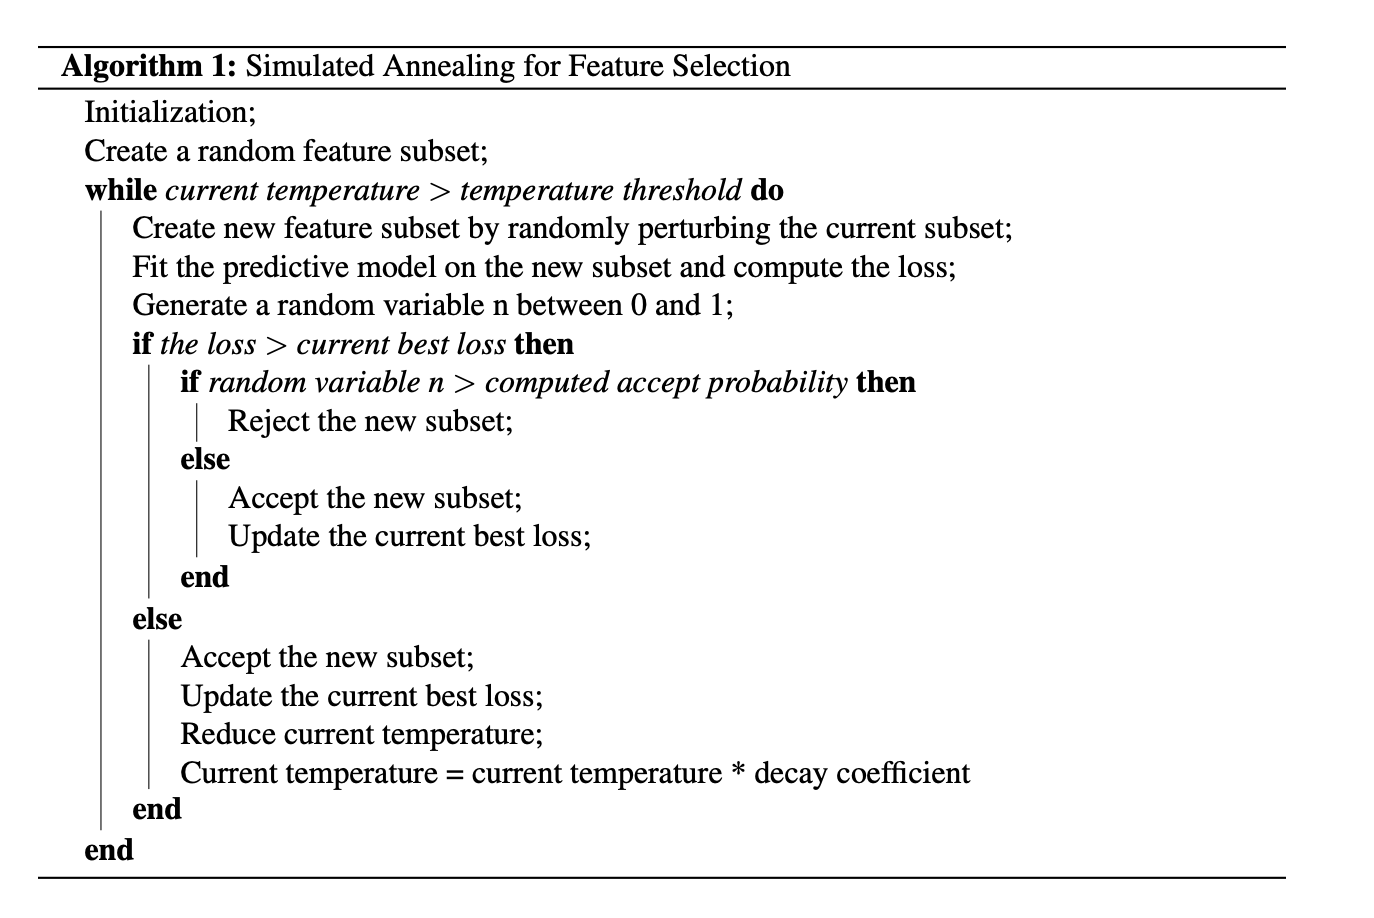

# Новый раздел

In [70]:
import random
import numpy as np
from sklearn.model_selection import KFold

random.seed()
np.random.seed()

class Simulated_Annealing(object):
    """
    Simulated Annealing Algorithm for feature selection

    Parameters
    ----------
    init_temp: float, default: 100.0
        The initial temperature

    min_temp: float, default: 1.0
        The minimum temperature to stop

    max_perturb: float, default: 0.2
        The maximum percentage of perturbance genarated

    alpha: float, default: 0.98
        The decay coefficient of temperature

    k: float, default: 1.0
        The constant for computing probability

    loss_func: object
        The loss function of the ML task.
        loss_func(y_true, y_pred) should return the loss.

    iteration: int, default: 50
        Number of iteration when temperature level is above min_temp each time.

    estimator: object
        A supervised learning estimator
        It has to have the `fit` and `predict` method (or `predict_proba` method for classification)

    predict_type: string, default="predict"
        Final prediction type.
        - For some classification loss functions, probability output is required.
          Should set predict_type to "predict_proba"

    Attributes
    ----------
    best_sol: np.array of int
        The index of the best subset of features.

    best_loss: float
        The loss associated with the best_sol

    References
    ----------
    1. https://blog.csdn.net/Joseph__Lagrange/article/details/94410317
    2. https://github.com/JeromeBau/SimulatedAnnealing/blob/master/gibbs_annealing.py

    """


    def __init__(self, loss_func, estimator, init_temp = 100.0, min_temp = 0.01, k = 1.0,
                 max_perturb = 0.2, alpha = 0.98, iteration = 50, predict_type = 'predict'):

        #### check type
        if not hasattr(estimator, 'fit'):
            raise ValueError('Estimator doesn\' have fit method')
        if not hasattr(estimator, 'predict') and not hasattr(estimator, 'predict_proba'):
            raise ValueError('Estimator doesn\' have predict or predict_proba method')

        for instant in [init_temp, min_temp, k, max_perturb, alpha]:
            if type(instant) != float:
                raise TypeError(f'{instant} should be float type')

        if type(iteration) != int:
            raise TypeError(f'{iteration} should be int type')

        if predict_type not in ['predict', 'predict_proba']:
            raise ValueError('predict_type should be "predict" or "predict_proba"')

        self.loss_func = loss_func
        self.estimator = estimator
        self.init_temp = init_temp
        self.min_temp = min_temp
        self.k = k
        self.max_perturb = max_perturb
        self.alpha = alpha
        self.iteration = iteration
        self.predict_type = predict_type
        self.loss_dict = dict()

    def _judge(self, new_cost, old_cost, temp):

        delta_cost = new_cost - old_cost

        if delta_cost < 0: # new solution is better
            proceed = 1
        else:
            probability = np.exp(-1 * delta_cost / (self.k * temp))
            if probability > np.random.random():
                proceed = 1

            else:
                proceed = 0

        return proceed

    def _get_neighbor(self, num_feature, current_sol, max_perturb):

        all_feature = np.ones(shape=(num_feature,)).astype(bool)
        outside_feature = np.where(all_feature != current_sol)[0]
        inside_feature = np.where(all_feature == current_sol)[0]
        num_perturb_in = int(max(np.ceil(len(inside_feature) * max_perturb),1))
        num_perturb_out = int(max(np.ceil(len(outside_feature) * max_perturb),1))
        if len(outside_feature) == 0:
            feature_in = np.array([])
        else:
            feature_in = np.random.choice(outside_feature,
                                          size = min(len(outside_feature),
                                                 np.random.randint(0, num_perturb_in + 1)),
                                          replace = False) # uniform distribution
        if len(inside_feature) == 0:
            feature_out = np.array([])
        else:
            feature_out = np.random.choice(inside_feature ,
                                           size = min(len(inside_feature),
                                                 np.random.randint(0, num_perturb_out + 1)),
                                           replace = False) # uniform distribution
        feature_change = np.append(feature_in, feature_out).astype(int)
        all_feature[feature_change] = 1 - all_feature[feature_change]

        return all_feature

    def _get_cost(self, X, y, estimator, loss_func, X_test = None, y_test = None):

        estimator.fit(X, y.ravel())
        if type(X_test) is np.ndarray:
            if self.predict_type == "predict_proba": # if loss function requires probability
                y_test_pred = estimator.predict_proba(X_test)
                return loss_func(y_test, y_test_pred)
            else:
                y_test_pred = estimator.predict(X_test)
                return loss_func(y_test, y_test_pred)

        y_pred = estimator.predict(X)

        return loss_func(y, y_pred)


    def _cross_val(self, X, y, estimator, loss_func, cv):

        loss_record = []

        for train_index, test_index in KFold(n_splits = cv).split(X):  # k-fold

            try:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                estimator.fit(X_train, y_train.ravel())

                if self.predict_type == "predict_proba":
                    y_test_pred = estimator.predict_proba(X_test)
                    loss = loss_func(y_test, y_test_pred)
                    loss_record.append(loss)
                else:
                    y_test_pred = estimator.predict(X_test)
                    loss = loss_func(y_test, y_test_pred)
                    loss_record.append(loss)
            except:
                continue

        return np.array(loss_record).mean()

    def fit(self, X_train, y_train, cv = None, X_val = None, y_val = None,
            init_sol = None, stop_point = 5):


        """
        Fit method.

        Parameters
        ----------
        X_train: numpy array shape = (n_samples, n_features).
            The training input samples.

        y_train: numpy array, shape = (n_samples,).
            The target values (class labels in classification, real numbers in regression).

        cv: int or None, default = None
            Specify the number of folds in KFold. None means SA will not use
            k-fold cross-validation results to select features.
            [1] If cv = None and X_val = None, the SA will evaluate each subset on trainset.
            [2] If cv != None and X_val = None, the SA will evaluate each subset on generated validation set using k-fold.
            [3] If cv = None and X_val != None, the SA will evaluate each subset on the user-provided validation set.

        X_val: numpy array, shape = (n_samples, n_features) or None. default = None.
            The validation input samples. None means no validation set is provoded.
            [1] If cv = None and X_val = None, the SA will evaluate each subset on trainset.
            [2] If cv != None and X_val = None, the SA will evaluate each subset on generated validation set using k-fold.
            [3] If cv = None and X_val != None, the SA will evaluate each subset on the user-provided validation set.

        y_val: numpy array, shape = (n_samples, ) or None. default = None.
            The validation target values (class labels in classification, real numbers in regression).

        init_sol: numpy array, shape = (num_feautre, ) or None. default = None.
            The initial solution provided by the user. It should contain bools.
            A good inital solution will save SA algorithm a lot of searching time.
            None means the SA will randomly generated a inital solution.

        stop_point: int, default = 5.
            The stopping conditions. If the optimal loss keeps the same for a few iterantions, then it will stop.

        Returns
        -------
        self : object

        """

        # make sure input has two dimensions
        assert len(X_train.shape) == 2
        num_feature = X_train.shape[1]

        # get initial solution
        if init_sol == None:
            init_sol = np.random.randint(2, size=num_feature)
            while sum(init_sol)==0:
                init_sol = np.random.randint(2, size=num_feature)

        current_sol = init_sol
        if cv:
            current_loss = self._cross_val(X_train[:,current_sol], y_train,
                                     self.estimator, self.loss_func, cv)
            current_loss = np.round(current_loss, 4)

        elif type(X_val) is np.ndarray:
            current_loss = self._get_cost(X_train[:,current_sol], y_train, self.estimator,
                                    self.loss_func, X_val[:,current_sol], y_val)
            current_loss = np.round(current_loss, 4)

        else:
            current_loss = self._get_cost(X_train[:,current_sol], y_train, self.estimator,
                                    self.loss_func, None, None)
            current_loss = np.round(current_loss, 4)

        encoded_str = ''.join(['1' if x else '0' for x in current_sol])
        self.loss_dict[encoded_str] = current_loss
        temp_history = [self.init_temp]
        loss_history = [current_loss]
        sol_history = [current_sol]

        current_temp = self.init_temp
        current_temp = np.round(current_temp, 4)

        best_loss = current_loss
        best_sol = current_sol

        # start looping
        while current_temp > self.min_temp:
            for step in range(self.iteration):
                current_sol = self._get_neighbor(num_feature, current_sol, self.max_perturb)
                if len(current_sol) == 0:
                    current_loss = np.Inf
                else:
                    encoded_str = ''.join(['1' if x else '0' for x in current_sol])
                    if self.loss_dict.get(encoded_str):
                        current_loss = self.loss_dict.get(encoded_str)
                    else:
                        if cv:
                            current_loss = self._cross_val(X_train[:,current_sol], y_train,
                                                     self.estimator, self.loss_func, cv)
                            current_loss = np.round(current_loss, 4)

                        elif type(X_val) is np.ndarray:
                            current_loss = self._get_cost(X_train[:,current_sol], y_train, self.estimator,
                                                    self.loss_func, X_val[:,current_sol], y_val)
                            current_loss = np.round(current_loss, 4)

                        else:
                            current_loss = self._get_cost(X_train[:,current_sol], y_train, self.estimator,
                                                    self.loss_func, None, None)
                            current_loss = np.round(current_loss, 4)
                        self.loss_dict[encoded_str] = current_loss

                if (current_loss - best_loss) <= 0: # update temperature
                    current_temp = current_temp * self.alpha
                    current_temp = np.round(current_temp, 4)

                # judge
                if self._judge(current_loss, best_loss, current_temp): # take new solution
                    best_sol = current_sol
                    best_loss = current_loss

            # keep record
            temp_history.append(current_temp)
            loss_history.append(best_loss)
            sol_history.append(best_sol)

            # debugging Pipeline
            # print(f"Current temperature is {current_temp}")
            # print(f"Current best loss is {best_loss}")
            # print(f"Current best solution is {best_sol}")

            # check stopping condition
            if len(loss_history) > stop_point:
                if len(np.unique(loss_history[-1 * stop_point : ])) == 1:
                    print(f"Stopping condition reached!")
                    break

        best_idx = np.argmin(loss_history)
        self.best_sol = sol_history[best_idx]
        self.best_loss = loss_history[best_idx]

    def transform(self, X):
        """
        Transform method.

        Parameters
        ----------
        X: numpy array shape = (n_samples, n_features).
            The data set needs feature reduction.

        Returns
        -------
        transform_X: numpy array shape = (n_samples, n_best_features).
            The data set after feature reduction.

        """
        transform_X = X[:, self.best_sol]
        return transform_X

**Пример для задачи регрессии**:


In [77]:
#from SA import Simulated_Annealing  # Импортируем скрипт с реализацией SA

# Загружаем набор данных
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Определяем модель для оценки подмножеств признаков
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

clf = ExtraTreesRegressor(n_estimators=25)
selector = Simulated_Annealing(loss_func=mean_squared_error, estimator=clf,
                               init_temp=0.2, min_temp=0.005, iteration=10, alpha=0.9)

# Обучаем на тренировочном наборе с использованием 5-кратной кросс-валидации
selector.fit(X_train=train_set, y_train=train_y, cv=5)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Лучшее подмножество признаков и соответствующая ошибка
print("Лучшее подмножество признаков:", selector.best_sol)
print("Ошибка лучшего подмножества:", selector.best_loss)

Лучшее подмножество признаков: [ True  True False  True  True  True  True  True]
Ошибка лучшего подмножества: 0.3508


### Пример для задачи классификации



In [74]:
import numpy as np
import random
#from SA import Simulated_Annealing

# Загружаем набор данных
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный, валидационный и тестовый наборы
train_set = X[0:100, :]
val_set = X[100:120, :]
test_set = X[120:, :]

train_y = y[0:100]
val_y = y[100:120]
test_y = y[120:]

# Сбрасываем случайное зерно
random.seed()
np.random.seed()

# Определяем модель для оценки подмножеств признаков
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss

clf = ExtraTreesClassifier(n_estimators=25)
selector = Simulated_Annealing(loss_func=log_loss, estimator=clf,
                               init_temp=0.2, min_temp=0.005, iteration=10,
                               alpha=0.9, predict_type='predict_proba')

# Обучаем на тренировочном наборе с использованием валидационного набора
selector.fit(X_train=train_set, y_train=train_y, X_val=val_set, y_val=val_y, stop_point=10)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Лучшее подмножество признаков и соответствующая ошибка
print("Лучшее подмножество признаков:", selector.best_sol)
print("Ошибка лучшего подмножества:", selector.best_loss)

Лучшее подмножество признаков: [ True  True  True  True]
Ошибка лучшего подмножества: 0.0083



**Объяснение**:
- В примере для регрессии используется набор данных `California Housing`, где признаки непрерывные, а целевая переменная непрерывная.
- В примере для классификации используется набор данных `Iris`, где признаки непрерывные, а целевая переменная категориальная.
- Алгоритм SA позволяет находить оптимальные подмножества признаков, избегая локальных оптимумов.


# Генетический алгоритм (Genetic Algorithm, GA)

**Генетический алгоритм** — это стохастический метод оптимизации, основанный на концепциях эволюционной биологии. Он имитирует процесс эволюции в природе и решает задачу оптимизации, позволяя решениям "размножаться" и создавать новые решения (поколения) с помощью операций "скрещивания" (crossover) и "мутации" (mutation). Алгоритм также включает концепцию конкуренции, позволяя выживать только наиболее приспособленным решениям (в нашем случае — подмножествам признаков, которые приводят к наименьшей ошибке). GA сходится к оптимальному решению после определенного числа поколений.

Я также написал [python-скрипт](GA.py) для реализации генетического алгоритма. Он предоставляет два алгоритма: 'one-max' и 'NSGA2'. 'One-max' — это традиционный GA с одной целевой функцией (минимизация ошибки), а 'NSGA2' — это многокритериальный GA, который минимизирует как ошибку, так и количество признаков в подмножестве.

Скрипт поддерживает как задачи классификации, так и регрессии, а также предоставляет возможность кросс-валидации.

**Псевдокод генетического алгоритма**:



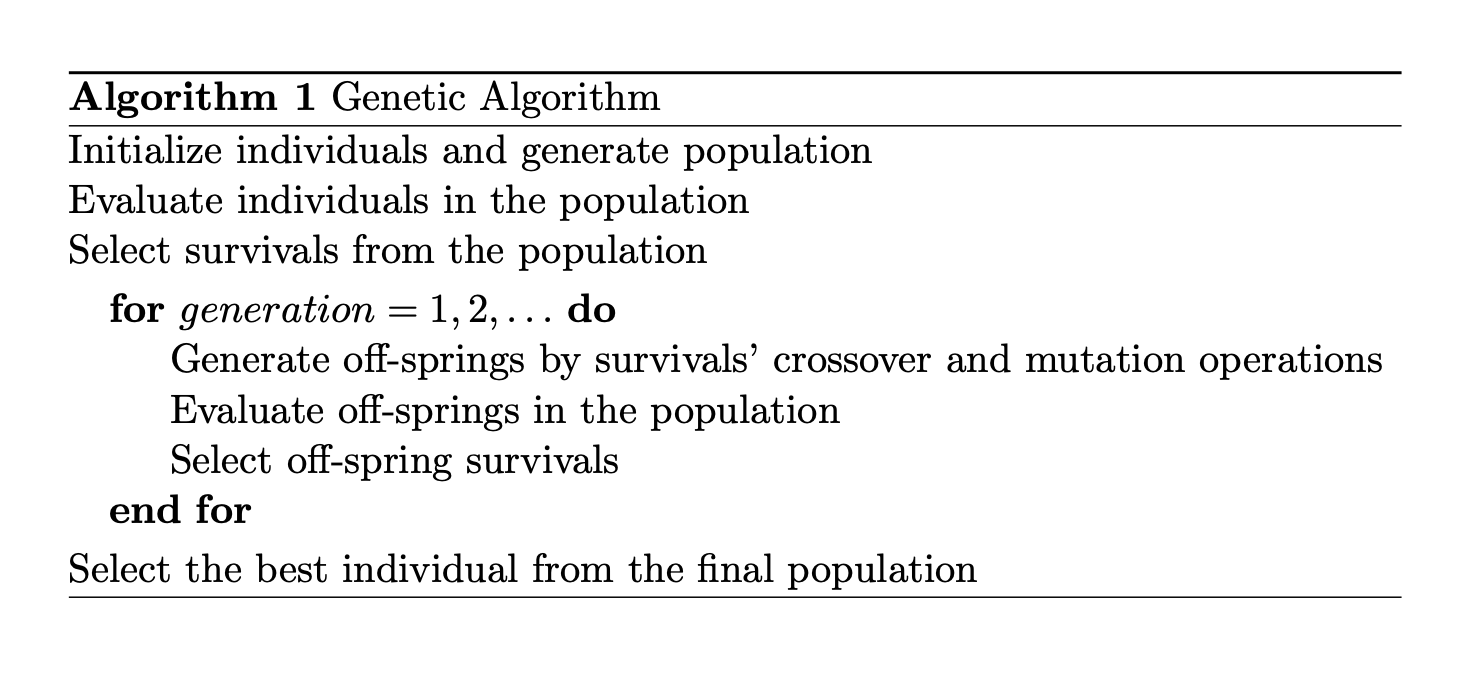

# Новый раздел

In [78]:
import random
import numpy as np
from tqdm import tqdm
import random
from sklearn.model_selection import KFold
from deap import base, creator, tools, algorithms

random.seed()
np.random.seed()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

class Genetic_Algorithm(object):
    """
    Genetic Algorithm Algorithm for feature selection

    Parameters
    ----------
    n_pop: int, default =20
        The number of population

    n_gen: int, default = 20
        The number of generation

    both: boolean, default = True
        Whether offsprings can result from both crossover and mutation
        If False, offsprings can result from one of them.

    n_children: int, default = None
        The number of children to produce when offsprings can only result from one of the operations
            including crossover, mutation and reproduction
        Default None will set n_children = n_pop
        n_children corresponds with the lambda_ parameter in deap.algorithms.varOr

    cxpb: float, default = 0.5
        The probability of mating two individuals
        The sum of cxpb and mutpb shall be in [0,1]

    mutpb: float, default = 0.3
        The probability of mutating an individual
        The sum of cxpb and mutpb shall be in [0,1]

    cx_indpb: float, default = 0.25
        The independent probabily for each attribute to be exchanged under uniform crossover.

    mu_indpb: floatt, default = 0.25
        The independent probability for each attribute to be flipped under mutFlipBit.

    algorithm: string, default="one-max"
        The offspring selection algorithm
        "NSGA2" is also available

    loss_func: object
        The loss function of the ML task.
        loss_func(y_true, y_pred) should return the loss.

    estimator: object
        A supervised learning estimator
        It has to have the `fit` and `predict` method (or `predict_proba` method for classification)

    predict_type: string, default="predict"
        Final prediction type.
        - For some classification loss functions, probability output is required.
          Should set predict_type to "predict_proba"

    Attributes
    ----------
    best_sol: np.array of int
        The index of the best subset of features.

    best_loss: float
        The loss associated with the best_sol

    loss_dict: dictionary
        Store the evaluation results to speed up fitting process

    References
    ----------
    1. https://deap.readthedocs.io/en/master/index.html
    2. https://github.com/kaushalshetty/FeatureSelectionGA
    3. Haupt, R. L. (1995). An introduction to genetic algorithms for electromagnetics.
        IEEE Antennas and Propagation Magazine, 37(2), 7-15.
    4. Deb, K., Pratap, A., Agarwal, S., & Meyarivan, T. A. M. T. (2002). A fast and elitist multiobjective genetic algorithm: NSGA-II.
        IEEE transactions on evolutionary computation, 6(2), 182-197.
    5. Mkaouer, W., Kessentini, M., Shaout, A., Koligheu, P., Bechikh, S., Deb, K., & Ouni, A. (2015). Many-objective software remodularization using NSGA-III.
        ACM Transactions on Software Engineering and Methodology (TOSEM), 24(3), 1-45.
    6. Fortin, F. A., Rainville, F. M. D., Gardner, M. A., Parizeau, M., & Gagné, C. (2012). DEAP: Evolutionary algorithms made easy.
    	Journal of Machine Learning Research, 13(Jul), 2171-2175.

    """

    def __init__(self, loss_func, estimator, n_pop = 20, n_gen = 20, both = True, n_children = None,
                 cxpb = 0.5, mutpb = 0.2, cx_indpb = 0.25, mu_indpb = 0.25,
                 algorithm = "one-max", predict_type = 'predict'):

        #### check type
        if not hasattr(estimator, 'fit'):
            raise ValueError('Estimator doesn\' have fit method')
        if not hasattr(estimator, 'predict') and not hasattr(estimator, 'predict_proba'):
            raise ValueError('Estimator doesn\' have predict or predict_proba method')

        for instant in [cxpb, mutpb, cx_indpb, mu_indpb]:
            if type(instant) != float:
                raise TypeError(f'{instant} should be float type')
            if (instant > 1) or (instant) < 0:
                raise ValueError(f'{instant} should be within range [0,1]')

        for instant in [n_pop, n_gen]:
            if type(instant) != int:
                raise TypeError(f'{instant} should be int type')

        if type(both) != bool:
            raise TypeError(f'{both} should be boolean type')

        if predict_type not in ['predict', 'predict_proba']:
            raise ValueError('predict_type should be "predict" or "predict_proba"')

        if algorithm not in ['one-max', 'NSGA2']:
            raise ValueError('algorithm should be "one-max" or "NSGA2"')

        if not n_children:
            n_children = n_pop

        if type(n_children) != int:
            raise TypeError(f'{n_children} should be int type')

        if (cxpb + mutpb) > 1.0:
            raise ValueError(f'The sum of cxpb and mutpb shall be in [0,1]')

        self.n_pop = n_pop
        self.n_gen = n_gen
        self.both = both
        self.n_children = n_children
        self.cxpb = cxpb
        self.mutpb = mutpb
        self.cx_indpb = cx_indpb
        self.mu_indpb = mu_indpb
        self.algorithm = algorithm
        self.loss_func = loss_func
        self.estimator = estimator
        self.predict_type = predict_type
        self.loss_dict = dict()

    def _get_cost(self, X, y, estimator, loss_func, X_test = None, y_test = None):

        estimator.fit(X, y.ravel())
        if type(X_test) is np.ndarray:
            if self.predict_type == "predict_proba": # if loss function requires probability
                y_test_pred = estimator.predict_proba(X_test)
                return loss_func(y_test, y_test_pred)
            else:
                y_test_pred = estimator.predict(X_test)
                return loss_func(y_test, y_test_pred)

        y_pred = estimator.predict(X)

        return loss_func(y, y_pred)


    def _cross_val(self, X, y, estimator, loss_func, cv):

        loss_record = []

        for train_index, test_index in KFold(n_splits = cv).split(X):  # k-fold

            try:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                estimator.fit(X_train, y_train.ravel())

                if self.predict_type == "predict_proba":
                    y_test_pred = estimator.predict_proba(X_test)
                    loss = loss_func(y_test, y_test_pred)
                    loss_record.append(loss)
                else:
                    y_test_pred = estimator.predict(X_test)
                    loss = loss_func(y_test, y_test_pred)
                    loss_record.append(loss)
            except:
                continue

        return np.array(loss_record).mean()

    def _eval_fitness(self, individual):

        individual = [True if x else False for x in individual]

        if sum(individual) == 0:
            current_loss = np.Inf
        else:
            encoded_str = ''.join(['1' if x else '0' for x in individual])
            if self.loss_dict.get(encoded_str):
                current_loss = self.loss_dict.get(encoded_str)
            else:
                if self.cv:
                    current_loss = self._cross_val(self.X_train[:,individual], self.y_train,
                                                   self.estimator, self.loss_func, self.cv)
                    current_loss = np.round(current_loss, 4)

                elif type(self.X_val) is np.ndarray:
                    current_loss = self._get_cost(self.X_train[:,individual], self.y_train,
                                                     self.estimator, self.loss_func,
                                                     self.X_val[:,individual], self.y_val)
                    current_loss = np.round(current_loss, 4)

                else:
                    current_loss = self._get_cost(self.X_train[:,individual], self.y_train,
                                                  self.estimator, self.loss_func, None, None)
                    current_loss = np.round(current_loss, 4)
                self.loss_dict[encoded_str] = current_loss

        if self.algorithm == "one-max":
            return current_loss,
        else:
            return current_loss, sum(individual)

    def fit(self, X_train, y_train, cv = None, X_val = None, y_val = None,
            init_sol = None, stop_point = 5):


        """
        Fit method.

        Parameters
        ----------
        X_train: numpy array shape = (n_samples, n_features).
            The training input samples.

        y_train: numpy array, shape = (n_samples,).
            The target values (class labels in classification, real numbers in regression).

        cv: int or None, default = None
            Specify the number of folds in KFold. None means SA will not use
            k-fold cross-validation results to select features.
            [1] If cv = None and X_val = None, the GA will evaluate each subset on trainset.
            [2] If cv != None and X_val = None, the GA will evaluate each subset on generated validation set using k-fold.
            [3] If cv = None and X_val != None, the GA will evaluate each subset on the user-provided validation set.

        X_val: numpy array, shape = (n_samples, n_features) or None. default = None.
            The validation input samples. None means no validation set is provoded.
            [1] If cv = None and X_val = None, the GA will evaluate each subset on trainset.
            [2] If cv != None and X_val = None, the GA will evaluate each subset on generated validation set using k-fold.
            [3] If cv = None and X_val != None, the GA will evaluate each subset on the user-provided validation set.

        y_val: numpy array, shape = (n_samples, ) or None. default = None.
            The validation target values (class labels in classification, real numbers in regression).

        Returns
        -------
        self : object

        """

        # make sure input has two dimensions
        assert len(X_train.shape) == 2
        num_feature = X_train.shape[1]

        # save them for _eval_fitness function
        self.X_train = X_train
        self.y_train = y_train
        self.cv = cv
        self.X_val = X_val
        self.y_val = y_val

        # creator
        if self.algorithm == "one-max":
            creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # minimize the loss
            creator.create("Individual", list, fitness=creator.FitnessMin)
        else:
            creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -0.1))
            creator.create("Individual", list, fitness=creator.FitnessMulti)

        # register
        toolbox = base.Toolbox()
        toolbox.register("gene", random.randint, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.gene, n = num_feature)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual,
                         n = self.n_pop)
        toolbox.register("evaluate", self._eval_fitness)
        toolbox.register("mate", tools.cxUniform, indpb = self.cx_indpb)
        toolbox.register("mutate", tools.mutFlipBit, indpb = self.mu_indpb)

        if self.algorithm == "one-max":
            toolbox.register("select", tools.selTournament, tournsize=5)
        else:
            toolbox.register("select", tools.selNSGA2)

        # start evolution
        # evaluate inital population
        population = toolbox.population()
        fits = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fits):
            ind.fitness.values = fit

        # evolving
        for gen in tqdm(range(self.n_gen)):
            if self.both:
                offspring = algorithms.varOr(population, toolbox,
                                              lambda_ = self.n_children, cxpb = self.cxpb,
                                              mutpb = self.mutpb)
            else:
                offspring = algorithms.varAnd(population, toolbox, cxpb = self.cxpb,
                                              mutpb = self.mutpb)
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            if self.algorithm == 'one-max':
                population = toolbox.select(offspring, k = self.n_pop)
            else:
                population = toolbox.select(offspring + population, k = self.n_pop)

        fits = list(toolbox.map(toolbox.evaluate, population))
        if self.algorithm != "one-max":
            fits = [x[0] for x in fits]

        try:
            best_idx = np.argmin(np.array(fits))
            self.best_sol = [True if x else False for x in population[best_idx]]
            self.best_loss = fits[best_idx]

            if np.isinf(self.best_loss): # if best loss is inf
                best_key = min([(value, key) for key, value in self.loss_dict.items()])[1]
                self.best_sol = [True if x == '1' else False for x in best_key]
                self.best_loss = min([(value, key) for key, value in self.loss_dict.items()])[0]
        except:
            best_key = min([(value, key) for key, value in self.loss_dict.items()])[1]
            self.best_sol = [True if x == '1' else False for x in best_key]
            self.best_loss = min([(value, key) for key, value in self.loss_dict.items()])[0]

    def transform(self, X):
        """
        Transform method.

        Parameters
        ----------
        X: numpy array shape = (n_samples, n_features).
            The data set needs feature reduction.

        Returns
        -------
        transform_X: numpy array shape = (n_samples, n_best_features).
            The data set after feature reduction.

        """
        transform_X = X[:, self.best_sol]
        return transform_X



### Пример для задачи регрессии


In [73]:
#from GA import Genetic_Algorithm  # Импортируем скрипт с реализацией GA

# Загружаем набор данных
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Определяем модель для оценки подмножеств признаков
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

clf = ExtraTreesRegressor(n_estimators=25)
selector = Genetic_Algorithm(loss_func=mean_squared_error, estimator=clf,
                             n_gen=10, n_pop=20, algorithm='NSGA2')

# Обучаем на тренировочном наборе с использованием 5-кратной кросс-валидации
selector.fit(X_train=train_set, y_train=train_y, cv=5)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Лучшее подмножество признаков и соответствующая ошибка
print("Лучшее подмножество признаков:", selector.best_sol)
print("Ошибка лучшего подмножества:", selector.best_loss)

100%|██████████| 10/10 [03:33<00:00, 21.40s/it]

Лучшее подмножество признаков: [True, True, False, True, True, True, True, True]
Ошибка лучшего подмножества: 0.3525


### Пример для задачи классификации





In [75]:
import numpy as np
#from GA import Genetic_Algorithm

# Загружаем набор данных
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный, валидационный и тестовый наборы
train_set = X[0:100, :]
val_set = X[100:120, :]
test_set = X[120:, :]

train_y = y[0:100]
val_y = y[100:120]
test_y = y[120:]

# Сбрасываем случайное зерно
random.seed()
np.random.seed()

# Определяем модель для оценки подмножеств признаков
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss

clf = ExtraTreesClassifier(n_estimators=25)
selector = Genetic_Algorithm(loss_func=log_loss, estimator=clf,
                             n_gen=5, n_pop=10, predict_type='predict_proba')

# Обучаем на тренировочном наборе с использованием валидационного набора
selector.fit(X_train=train_set, y_train=train_y, X_val=val_set, y_val=val_y)

# Преобразуем наборы данных
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Лучшее подмножество признаков и соответствующая ошибка
print("Лучшее подмножество признаков:", selector.best_sol)
print("Ошибка лучшего подмножества:", selector.best_loss)

100%|██████████| 5/5 [00:00<00:00, 44.32it/s]

Лучшее подмножество признаков: [False, False, True, True]
Ошибка лучшего подмножества: (0.0064,)




## Встроенные методы (Embedded Methods)

Процесс выбора признаков в **фильтровых методах** не зависит от моделей машинного обучения, поэтому они могут выбирать признаки, которые менее важны для модели, что может привести к плохой производительности.

**Методы-обертки** используют предопределенные модели машинного обучения для выбора лучших признаков. Однако, поскольку им необходимо обучать модели множество раз на большом количестве подмножеств, они требуют значительного времени обработки, хотя обычно приводят к лучшей производительности, чем фильтровые методы.

**Встроенные методы** интегрируют процесс выбора признаков в процесс обучения модели. Они обучаются на лучшем подмножестве признаков одновременно с созданием модели. Таким образом, по сравнению с фильтровыми методами, они обычно имеют лучшую производительность. По сравнению с методами-обертками, они экономят время и вычислительные ресурсы.

### Сравнение трех подходов

| Аспект | Фильтровые методы | Методы-обертки | Встроенные методы |
|--|-|-|-|
| Зависимость от модели | Нет | Да | Да |
| Требование к кросс-валидации | Возможно (можно использовать CV для выбора количества признаков) | Да | Возможно (можно использовать CV для выбора количества признаков) |
| Время обработки | Короткое | Длительное | Среднее |
| Ограничения на модели | Нет | Нет | Да (линейные модели с L1 или L2 нормой или модели на основе деревьев) |



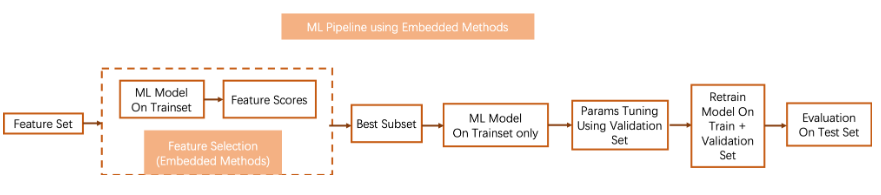



# Методы, основанные на регуляризации (Regularization-Based Methods)

Многие модели машинного обучения вводят штрафы (L1-норма или L2-норма) в свои функции потерь, чтобы предотвратить проблему переобучения. L1-регуляризация в линейных моделях (таких как Linear SVC, Logistic Regression, Linear Regression) стремится уменьшить коэффициенты некоторых признаков до нуля, что приводит к разреженным решениям. Таким образом, мы можем оценить важность каждого признака по его коэффициенту в линейной модели с регуляризацией. Чем выше коэффициент, тем важнее признак в линейной модели.

Мы можем использовать функцию `SelectFromModel` из `sklearn` для удаления признаков с низкими или нулевыми коэффициентами.



### Lasso-регрессия (Linear Regression с L1-нормой)

**Формула**:

Lasso-регрессия минимизирует следующую функцию потерь:

$$
\text{Loss} = \frac{1}{2n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} |w_j|
$$

где:
- $y_i$ — истинное значение целевой переменной,
- $\hat{y}_i$ — предсказанное значение,
- $w_j$ — коэффициент признака $j$,
- $\alpha$ — параметр регуляризации (чем больше $\alpha$, тем сильнее штраф).

**Пример**:



In [56]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.datasets import fetch_california_housing

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Создаем модель Lasso
clf = Lasso(alpha=0.001)
clf.fit(train_set, train_y)

# Выводим коэффициенты
print("Коэффициенты:", np.round(clf.coef_, 3))

# Выбираем признаки с коэффициентами выше порога
selector = SelectFromModel(clf, prefit=True, threshold=1e-5)
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Получаем индексы выбранных признаков
selected_features = selector.get_support(indices=True)
print("Выбранные признаки:", selected_features)

# Проверяем, что выбранные признаки соответствуют ожидаемым
assert np.array_equal(transformed_train, train_set[:, selected_features])
assert np.array_equal(transformed_test, test_set[:, selected_features])

print("Проверка прошла успешно!")

Коэффициенты: [ 0.439  0.007 -0.099  0.586 -0.    -0.008 -0.384 -0.365]
Выбранные признаки: [0 1 2 3 4 5 6 7]
Проверка прошла успешно!





### Логистическая регрессия (с L1-нормой)

**Формула**:

Логистическая регрессия с L1-нормой минимизирует следующую функцию потерь:

$$
\text{Loss} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] + \alpha \sum_{j=1}^{p} |w_j|
$$

**Пример**:



In [53]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Загружаем набор данных
iris = load_iris()
X, y = iris.data, iris.target

# Перемешиваем данные
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:100, :]
test_set = X[100:, :]
train_y = y[0:100]

# Стандартизируем данные
scaler = StandardScaler()
standardized_train = scaler.fit_transform(train_set)
standardized_test = scaler.transform(test_set)

# Создаем модель логистической регрессии
clf = LogisticRegression(penalty='l1', C=0.7, random_state=1234, solver='liblinear')
clf.fit(standardized_train, train_y)

# Выводим коэффициенты
print("Коэффициенты:", np.round(clf.coef_, 3))

# Выбираем признаки с коэффициентами выше порога
selector = SelectFromModel(clf, prefit=True, threshold=1e-5)
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Проверяем выбранные признаки
assert np.array_equal(transformed_train, train_set[:, [1, 2, 3]])  # Выбираем 2-й, 3-й и 4-й признаки
assert np.array_equal(transformed_test, test_set[:, [1, 2, 3]])

Коэффициенты: [[ 0.     1.    -3.453 -0.159]
 [ 0.    -1.201  0.053  0.   ]
 [ 0.     0.     1.335  3.267]]





### LinearSVR / LinearSVC

**Формула**:

LinearSVR минимизирует следующую функцию потерь:

$$
\text{Loss} = \frac{1}{2n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} |w_j|
$$

**Пример**:


In [54]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Стандартизируем данные
scaler = StandardScaler()
standardized_train = scaler.fit_transform(train_set)
standardized_test = scaler.transform(test_set)

# Создаем модель LinearSVR
clf = LinearSVR(C=0.0001, random_state=123)
clf.fit(standardized_train, train_y)

# Выводим коэффициенты
print("Коэффициенты:", np.round(clf.coef_, 3))

# Выбираем признаки с коэффициентами выше порога
selector = SelectFromModel(clf, prefit=True, threshold=1e-2)
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Проверяем выбранные признаки
assert np.array_equal(transformed_train, train_set[:, [0, 1, 2, 3, 4, 6, 7]])  # Удаляем 5-й признак
assert np.array_equal(transformed_test, test_set[:, [0, 1, 2, 3, 4, 6, 7]])

Коэффициенты: [ 0.254  0.026  0.026 -0.017  0.032 -0.01  -0.1   -0.037]





### Методы, основанные на деревьях (Tree-Based Methods)

Мощные модели на основе деревьев, такие как случайный лес, AdaBoost, XGBoost, записывают, как каждый признак используется для уменьшения потерь при разделении узлов дерева, и могут сообщать о важности каждого признака. Эти важности признаков можно использовать для отбора наиболее значимых признаков.

**Пример**:



Важности признаков: [0.52  0.045 0.031 0.026 0.027 0.138 0.106 0.107]


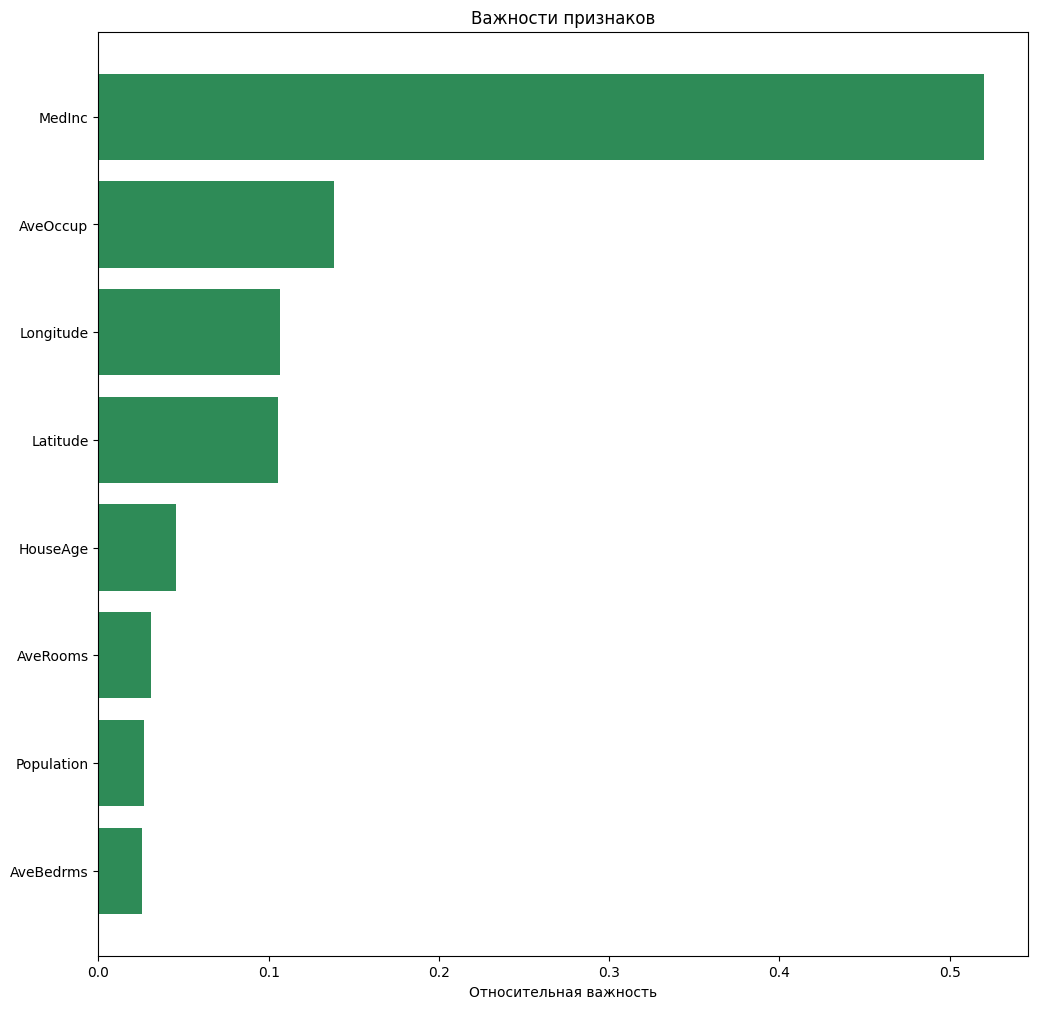

In [55]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

# Загружаем набор данных
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target

# Разделяем на тренировочный и тестовый наборы
train_set = X[0:15000, :]
test_set = X[15000:, :]
train_y = y[0:15000]

# Создаем модель случайного леса
clf = RandomForestRegressor(n_estimators=50, random_state=123)
clf.fit(train_set, train_y)

# Выводим важности признаков
print("Важности признаков:", np.round(clf.feature_importances_, 3))

# Визуализируем важности признаков
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12, 12))
plt.title('Важности признаков')
plt.barh(range(len(indices)), importances[indices], color='seagreen', align='center')
plt.yticks(range(len(indices)), np.array(dataset.feature_names)[indices])
plt.xlabel('Относительная важность')
plt.show()

# Выбираем признаки с важностью выше медианы
selector = SelectFromModel(clf, prefit=True, threshold='median')
transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)

# Проверяем выбранные признаки
assert np.array_equal(transformed_train, train_set[:, [0, 5, 6, 7]])  # Выбираем 1-й, 6-й, 7-й и 8-й признаки
assert np.array_equal(transformed_test, test_set[:, [0, 5, 6, 7]])